In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import anndata as ad

import sys
sys.path.append("/code/")
from thalamus_merfish_analysis import abc_load as abc
from thalamus_merfish_analysis import ccf_images as cimg
from thalamus_merfish_analysis import ccf_plots as cplots
from thalamus_merfish_analysis import ccf_erode as cerd
import thalamus_merfish_analysis.distance_metrics as dm

from colorcet import glasbey

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.size'] = 7
get_ipython().run_line_magic('matplotlib', 'inline') 

In [3]:
# set spatial column names to `_reconstructed` coordinate space
coords = '_reconstructed'

x_col = 'x'+coords
y_col = 'y'+coords
section_col = z_col = 'z'+coords

# level at which to compare labels
ccf_level = 'structure'

In [4]:
results_dir = '../../results/'

In [5]:
# load all cells in the brain
obs = abc.get_combined_metadata(realigned=False)

In [8]:
# generate ccf_images & boundaries for the left hemisphere only
ccf_images_left = abc.get_ccf_labels_image(resampled=True, 
                                           realigned=False, 
                                           subset_to_left_hemi=True)

ccf_boundaries_left = cimg.sectionwise_label_erosion(ccf_images_left, 
                                                distance_px=1, 
                                                fill_val=0, 
                                                return_edges=True)

In [21]:
# We can load & use the published color palettes for the ABC Atlas taxonomy
abc_palettes = {level: abc.get_taxonomy_palette(level) for level in 
                ['neurotransmitter','class', 'subclass','supertype','cluster']}

# We have also provided a secondary color palette for the cluster level that 
# attempts to increase the color contrast between spatially negihboring clusters
abc_palettes['cluster'] = abc.get_thalamus_cluster_palette() 

ccf_palette = abc.get_ccf_palette('substructure')
ccf_palette['ZI'] = ccf_palette.pop('ZI-unassigned') # need to fix a key error

In [9]:
# load in SpaGCN domain results
# temporarily a static file in '../code/resources' until I get a reproducible run setup for the spagcn capsule
spagcn_domains_df = pd.read_parquet('/code/thalamus_merfish_analysis/resources/spagcn_predicated_domains.parquet')
# need to convert to categories since they're imported as int64
spagcn_domains_df = spagcn_domains_df.astype('category')

# merge in & subset to just cells with SpaGCN domain predictions
obs_spagcn = pd.merge(obs, spagcn_domains_df, on='cell_label', how='inner')

# filter by thalamus coords to tighten up the image
obs_spagcn = abc.filter_by_thalamus_coords(obs_spagcn)

# erode the CCF structures
obs_spagcn_erode, ccf_label = cerd.label_cells_by_eroded_ccf(obs_spagcn.copy(), 
                                                             ccf_images_left, 
                                                             ccf_level=ccf_level)

In [10]:
# set the resolutions we want to visualize
resolution = 1.4
res_str = str(resolution)
predicted_col = f'res{res_str[0]}pt{res_str[-1]}'

## Fig. S3A-C | Domains vs subclasses/supertypes/clusters

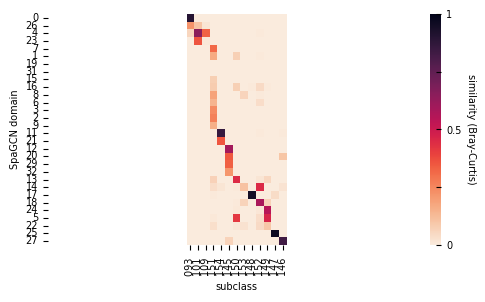

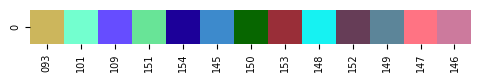

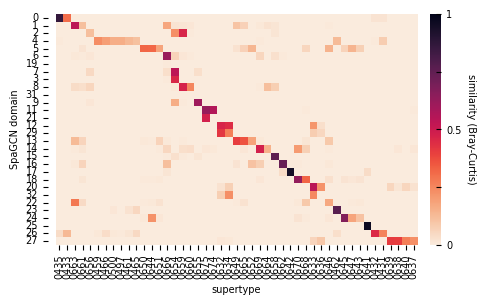

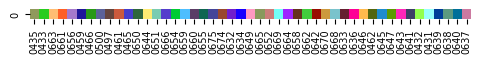

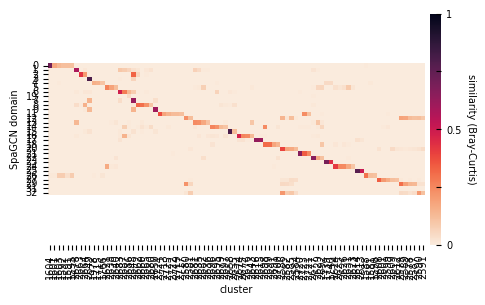

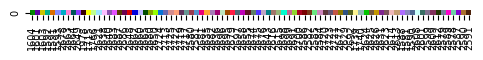

In [24]:
taxonomy_level = 'subclass'
for taxonomy_level in ['subclass', 'supertype', 'cluster']:
    dist, y_names, x_names = dm.cluster_distances_from_labels(
                                obs_spagcn, 
                                y_col=predicted_col, 
                                x_col=taxonomy_level,
                                y_names=sorted(obs_spagcn[predicted_col].unique()),
                                x_names=sorted(obs_spagcn[taxonomy_level].unique()),#subclasses_subset,
                                metric='braycurtis')
    # display(y_names)
    # display(x_names)

    y_order, x_order = dm.order_distances_x_to_y(dist, 
                                                 reorder_y=True, 
                                                 min_similarity_x=0.1)

    x_names_ids_only = [name[0:4] for name in x_names]

    fig = dm.plot_ordered_similarity_heatmap(dist, 
                                            y_order=y_order, 
                                            x_order=x_order, 
                                            y_names=y_names, 
                                            x_names=x_names_ids_only)
    ax = fig.gca()
    ax.axis('equal')
    ax.set_xlabel(f'{taxonomy_level}')
    ax.set_ylabel('SpaGCN domain')
    fig.set_size_inches(5.8,3)

    fig.savefig(f'{results_dir}/figS3_similarity_heatmap_{taxonomy_level}_vs_spaGCN_domains_reorderedY.pdf', 
                transparent=True, 
                bbox_inches='tight')
    
    # Plot colored labels for the x-axis categories
    fig_xlabel_colors = dm.plot_heatmap_xlabel_colors(x_names, 
                                                     x_order, 
                                                     abc_palettes[taxonomy_level])
    fig_xlabel_colors.set_size_inches(5.7,3)
    fig_xlabel_colors.savefig(f'{results_dir}/figS3_similarity_heatmap_{taxonomy_level}_vs_spaGCN_domains_xaxis_colors.pdf', 
                              transparent=True, 
                              bbox_inches='tight')